In [7]:
!python -m pip install pip install stellargraph chardet gensim

  Using cached stellargraph-1.2.1-py3-none-any.whl (435 kB)
  Using cached chardet-5.2.0-py3-none-any.whl (199 kB)
  Using cached gensim-4.3.2-cp38-cp38-macosx_10_9_x86_64.whl (24.1 MB)
  Using cached tensorflow-2.13.1-cp38-cp38-macosx_10_15_x86_64.whl (216.2 MB)
  Using cached smart_open-7.0.4-py3-none-any.whl (61 kB)
  Using cached wrapt-1.16.0-cp38-cp38-macosx_10_9_x86_64.whl (37 kB)
  Using cached tensorflow_io_gcs_filesystem-0.34.0-cp38-cp38-macosx_10_14_x86_64.whl (1.7 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached grpcio-1.62.2-cp38-cp38-macosx_10_10_universal2.whl (10.1 MB)
  Using cached tensorflow_estimator-2.13.0-py2.py3-none-any.whl (440 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl (26 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached numpy-1.24.3-cp38-cp38-macosx_10_9_x86_64.whl (19.8 MB)
  Using cached termcolor-2.4.0-py3-none-any.whl (7.7 kB)
  Using ca

In [17]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from tqdm import tqdm
from functools import reduce
import datetime
from datetime import datetime, timedelta
from collections import defaultdict, Counter
from utils import * 
import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.data import EdgeSplitter, BiasedRandomWalk, TemporalRandomWalk
from scipy.special import softmax
from tqdm import tqdm
import math

from math import isclose
from sklearn.decomposition import PCA
import multiprocessing
import sklearn.model_selection 
from gensim.models import Word2Vec
# python3 -m pip install tqdm seaborn 

# CM_Time() & Weekly Graph Construction

In [2]:
class temporalNetwork(): 
    def __init__(self, start_date, end_date, display_progress=False, location_grouping='kma', origin=None, facility_id=None, intermediate=None):
        """ 
        Note: 
            start_date and end_date should be both None as they are used as a signal to 
            CM_Time's run_simulation to whether construct a new graph or update the graph with new information 
        """
        self.display_progress = display_progress
        self.start_date=start_date
        self.end_date=end_date
        self.network=None
        self.origin_location_list=None
        self.location_grouping=location_grouping
        self.inbound_data = None 
        self.outbound_data = None

    def construct_network_graph(self):
        """ 
        Given an inbound and outbound dataframe, construct a network graph and stores it in the class variable self.network
        Args: 
            an_inbound_df (pd.DataFrame): inbound dataframe
            an_outbound_df (pd.DataFrame): outbound dataframe
            start_date (datetime): start date of the network graph
            end_date (datetime): end date of the network graph
            location_grouping(string): 'kma' or 'zip3'
        """
        # pull data & construct an empty multiDiGraph

        date = self.start_date.strftime("%Y-%m-%d") + "_" + self.end_date.strftime("%Y-%m-%d")
        an_inbound_df, an_outbound_df = pd.read_csv(f"inbound_{self.location_grouping}_data/inbound_data_{date}.csv"), pd.read_csv(f"outbound_{self.location_grouping}_data/outbound_data_{date}.csv")
        an_inbound_df.load_date, an_outbound_df.load_date = pd.to_datetime(an_inbound_df.load_date), pd.to_datetime(an_outbound_df.load_date)
        for colin, colout in zip(an_inbound_df.columns, an_outbound_df.columns): 
            if colin not in ["total_loads", "load_date"]: 
                an_inbound_df[colin] = an_inbound_df[colin].astype(str)
            if colout not in ["total_loads", "load_date"]:
                an_outbound_df[colout] = an_outbound_df[colout].astype(str)

        network_graph = nx.MultiDiGraph(name=f"original network", start_date=self.start_date, end_date=self.end_date)
        # network_graph = nx.DiGraph(name=f"original network", start_date=self.start_date, end_date=self.end_date)
        # idf, odf = an_inbound_df.copy(), an_outbound_df.copy()

        # idf.to_csv(f"data/inbound_data_{self.start_date}_{self.end_date}.csv", index=False)
        # odf.to_csv(f"data/outbound_data_{self.start_date}_{self.end_date}.csv", index=False)

        # add nodes & edges 
        node_1 = f"origin_{self.location_grouping}_id"
        node_2 = f"facility_{self.location_grouping}_id"
        node_3 = f"destination_{self.location_grouping}_id"

        network_graph = add_nodes_given_df(network_graph, an_inbound_df, [node_1, 'facility_id']) 
        network_graph = add_nodes_given_df(network_graph, an_outbound_df, ['facility_id', node_2, node_3]) 

        network_graph = add_edges_given_graph(network_graph, an_inbound_df, an_outbound_df, self.location_grouping)
        
        # update the variables 
        self.network = network_graph
        self.origin_location_list = an_inbound_df[f'origin_{self.location_grouping}_id'].unique()
        self.inbound_data, self.outbound_data = an_inbound_df, an_outbound_df
        if self.display_progress: print(f"Current time of the graph: {self.start_date} to {self.end_date}") 
        
    def move_to_next_week(self): 
        """ 
        Given the new week's inbound and outbound dataframes, 
        update self.network graph, self.start_date, and self.end_date to a week after current start date and end date 
        
        Args:
            next_inbound_df (pd.DataFrame): new week's inbound dataframe
            next_outbound_df (pd.DataFrame): new week's outbound dataframe
            display_progress (boolean): whether to display the progress of the function or not
        """
        # update the dates, pull new week's data, & store some informations
        self.start_date, self.end_date = self.start_date + timedelta(days=7), self.end_date + timedelta(days=7)
        date = self.start_date.strftime("%Y-%m-%d") + "_" + self.end_date.strftime("%Y-%m-%d")
        next_inbound_df, next_outbound_df = pd.read_csv(f"inbound_{self.location_grouping}_data/inbound_data_{date}.csv"), pd.read_csv(f"outbound_{self.location_grouping}_data/outbound_data_{date}.csv")
        next_inbound_df.load_date, next_outbound_df.load_date = pd.to_datetime(next_inbound_df.load_date), pd.to_datetime(next_outbound_df.load_date)
        for colin, colout in zip(next_inbound_df.columns, next_outbound_df.columns): 
            if colin not in ["total_loads", "load_date"]: 
                next_inbound_df[colin] = next_inbound_df[colin].astype(str)
            if colout not in ["total_loads", "load_date"]:
                next_outbound_df[colout] = next_outbound_df[colout].astype(str)

        network_graph = nx.MultiDiGraph(name=f"new network", start_date=self.start_date, end_date=self.end_date)
        # network_graph = nx.DiGraph(name=f"original network", start_date=self.start_date, end_date=self.end_date)
        # idf, odf = an_inbound_df.copy(), an_outbound_df.copy()

        # idf.to_csv(f"data/inbound_data_{self.start_date}_{self.end_date}.csv", index=False)
        # odf.to_csv(f"data/outbound_data_{self.start_date}_{self.end_date}.csv", index=False)

        # add nodes & edges 
        node_1 = f"origin_{self.location_grouping}_id"
        node_2 = f"facility_{self.location_grouping}_id"
        node_3 = f"destination_{self.location_grouping}_id"

        network_graph = add_nodes_given_df(network_graph, next_inbound_df, [node_1, 'facility_id']) 
        network_graph = add_nodes_given_df(network_graph, next_outbound_df, ['facility_id', node_2, node_3]) 

        network_graph = add_edges_given_graph(network_graph, next_inbound_df, next_outbound_df, self.location_grouping)

         # update the variables 
        self.network = network_graph
        self.origin_location_list = next_inbound_df[f'origin_{self.location_grouping}_id'].unique()
        self.inbound_data, self.outbound_data = next_inbound_df, next_outbound_df
        if self.display_progress: print(f"Current time of the graph: {self.start_date} to {self.end_date}") 
       

    def print_network_information(self, given_network, print_network_time=False): 
        """
        Given a network, print out the information of the network
        Args: 
            given_network (nx.MultiDiGraph): a network graph
        Returns: N/A
        """
        print("---------------------------------------------------------------------------------------------") 
        print(given_network)
        print(f"Is the given network a DAG for load_network?: {nx.is_directed_acyclic_graph(given_network)}")
        print(f"Number of self loops: {nx.number_of_selfloops(given_network)}")
        if print_network_time: print(f"Current time of the graph: {given_network.graph['start_date']} to {given_network.graph['end_date']}")
        else: print(f"Current time of the graph: {self.start_date} to {self.end_date}")


In [3]:
class CM_Finder():
    def __init__(self, location_grouping='kma', origin_location_list=None, network = None):
        self.network=network
        self.processed_network=None
        self.processed=False 
        self.origin_location_list=origin_location_list
        self.match_failure = None
        self.remove_failure = 0
        self.location_grouping=location_grouping
        
    def group_to_DiGraph(self, display_progress = False):
        """
        #TODO: explain why aggregate_faciility_zip then group_to_DiGraph (kma-> facility_zip -> kma to kma->kma->kma, aggregate to faciliy KMA)
        Assuming that self.network is constructed, 
        sums the edge weights for edges with the same nodes in self.network variable and 
        stores the new graph with aggregated edges in self.processed_network variable and returns False if successful 

        Args:
            display_progress (boolean): whether to display the progress of the function or not

        NOTE) disregards temporal factor 
        """
        if not self.network: 
            print("Please construct the network first")
            return None 
            
        new_name = self.network.name + " reduced"
        self.processed_network = nx.DiGraph(name=new_name)
        self.processed_network.add_nodes_from(self.network)

        if display_progress: print("Aggregating nodes by KMA...")
        for n1, n2 in self.network.edges():
            sum = 0 
            for inner_dict in self.network.get_edge_data(n1, n2).values(): 
                sum += inner_dict['capacity']
            self.processed_network.add_edge(n1, n2, capacity = sum)
        
        nx.set_edge_attributes(self.processed_network, to_integer(self.network.graph['end_date']), 'time')
        self.processed = True

In [4]:
class CM_Time(): 
    def __init__(self, location_grouping='kma', origin=None, facility_id=None, intermediate=None): 
        self.start_date=None
        self.end_date=None
        self.cm_network = None   
        self.cm_finder = None
        self.origin=origin
        self.facility_id=facility_id
        self.intermediate=intermediate
        self.location_grouping = location_grouping
        self.weekly_graphs = {}
    
    def update_dates(self): 
        """
        Updates the start and end date by 7 days
        """ 
        self.start_date += timedelta(days=7)
        self.end_date += timedelta(days=7)

    def construct_or_update_tg(self, filter_key='load_count', display_progress=False, display_path_info=False):
        """ 
        Either (1) creates a network graph given a start and end date 
            or (2) updates the network graph to the next week's graph 

        Args: 
            start_date, end_date: start & end date of the first two weeks of the simulation

        Returns: n/a
        """        
        # construct or update cm_finder.network 
        if not self.cm_network: 
            self.cm_network = temporalNetwork(self.start_date, self.end_date, display_progress, self.location_grouping, self.origin, self.facility_id, self.intermediate)
            self.cm_network.construct_network_graph()
            self.cm_finder = CM_Finder(location_grouping=self.location_grouping)
        else: 
            self.cm_network.move_to_next_week()

        self.cm_finder.origin_location_list = self.cm_network.origin_location_list
        self.cm_finder.network = self.cm_network.network
        
        # self.cm_finder.group_to_DiGraph(display_progress = display_progress)
        self.weekly_graphs[self.end_date] = self.cm_finder.network

    def temporal_query(self, start_date, temporal=True, looback = 7, number_of_weeks=None, termination_date = None, \
                    filter_key = "load_count", display_progress=False, display_path_info = False): 
        """
        Given a start date, run the simulation for number_of_weeks or until termination_date is reached.

        Args: 
            start_date: start date of the first week of the simulation
            temporal: if True, run the simulation for every two weeks, if False, run the simulation from start_date until end_date
            number_of_weeks: number of weeks to run the simulation for
            termination_date: date to stop the simulation
            filter_key: key to filter the network on (load_count or path_score)
            display_progress: if True, display progress bar
            display_path_info: if True, display path info

        Returns: a dictionary of simulation result for each week
            
        Note:
        * termination_date: termination date of the entire analysis, when end_date reaches termination_date, the query loop terminates,
        * end_date: the end date of the two-week window, will be updated every week

        - Once the parameters (location_grouping, origin, facility_id, intermediate) are used to initialise the cm_time class, 
          they will be used for any further analysis until new initialisation happens.
          query_weekly method will only perform analysis, no alterations can be made by calling solely this.

        - If temporal=True, --> end_date != termination_date, eventually at the end of simulations, end_date = termination_date
            and number_of_weeks is given, end_date = start_date + 13 days for the first simulation, termination_date = start_date + 7 days * number_of_weeks
            and termination_date is given, end_date = start_date + 13 days for the first simulation and termination_date=termination_date for the simulation
          If temporal=False --> end_date = termination_date 
            and number_of_weeks is given, end_date = start_date + 7 days * number_of_weeks for the simulation 
            and termination_date is given, end_date=termination_date for the simulation

        * simulation_results: a dictionary with key as the end_date and value as the simulation result
        """

        # create information needed for a new query with the given start_date and number_of_weeks
        # possible bug when end_date > termination_date.
        if temporal: 
            self.start_date, self.end_date = start_date, start_date + timedelta(days=looback-1)

            if number_of_weeks: termination_date = self.start_date + timedelta(days=7) * number_of_weeks
            elif termination_date: termination_date = termination_date
            else: raise Exception("Neither number of weeks nor termination date was given to set the simulation time period.")
        
            # run simulation for every two weeks until termination_date
            while self.end_date <= termination_date:    
                self.construct_or_update_tg(filter_key=filter_key, \
                                    display_progress=display_progress, display_path_info=display_path_info)
                self.update_dates() 
                
        else: 
            if number_of_weeks: self.start_date, self.end_date = start_date, start_date + timedelta(days=7) * number_of_weeks
            elif termination_date: self.start_date, self.end_date = start_date, termination_date
            else: raise Exception("Neither number of weeks nor termination date was given to set the simulation time period.")
            self.run_single_simulation(filter_key=filter_key, \
                                display_progress=display_progress, display_path_info=display_path_info)

        return self.weekly_graphs

    def if_edge(node1, node2, curr_graph): 
        adjacency_matrix = curr_graph

In [6]:
# k1, k2 = list(weekly_graphs.keys())[:2]
# weekly_graphs[k1] == weekly_graphs[k2]

False

In [5]:
cm_time = CM_Time(location_grouping = 'kma') 
weekly_graphs = cm_time.temporal_query(start_date=datetime(2021,1,1).date(), looback=7, termination_date= datetime(2021,1, 15).date(), \
                    display_progress=False, display_path_info = False)

In [5]:
cm_time = CM_Time(location_grouping = 'zip3') 
weekly_graphs = cm_time.temporal_query(start_date=datetime(2021,1,1).date(), looback=7, termination_date= datetime(2023,6, 1).date(), \
                    display_progress=False, display_path_info = False)

# Link Prediction Algorithm

In [6]:
def operator_l2(u, v):
    return (u - v) ** 2

def operator_sub(u, v):
    return (u - v)

binary_operator = operator_l2

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler


def link_examples_to_features(link_examples, transform_node):
    return [
        operator_l2(transform_node(src), transform_node(dst)) for src, dst in link_examples
    ]

def link_examples_to_features_sub(link_examples, transform_node):
    return [
        operator_sub(transform_node(src), transform_node(dst)) for src, dst in link_examples
    ]

def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter, penalty="l2") #, solver="liblinear")
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


In [36]:
def data_split(graph, prediction_window_size=2): 
    # graph = stellar graph
    # identify edges based on dates
    edges, weights = np.array(graph.edges(include_edge_weight=True)[0]), np.array(graph.edges(include_edge_weight=True)[1])
    lower_lim = sorted(list(set(weights)))[-prediction_window_size]
    index_test, index_train = np.where(weights >= lower_lim)[0], np.where(weights < lower_lim)[0]

    # create test & train edge sets
    test_pos_edges, test_time_labels = edges[index_test], weights[index_test]
    train_edges, train_time_labels = edges[index_train], weights[index_train]
    test_pos_edges_with_time_attribute = np.rec.fromarrays([test_pos_edges[:,0], test_pos_edges[:,1], test_time_labels])
    train_edges_with_time_attribute = np.rec.fromarrays([train_edges[:,0], train_edges[:,1], train_time_labels])

    # create test and train graph 
    train_graph = nx.MultiDiGraph()
    train_graph.add_weighted_edges_from(train_edges_with_time_attribute,weight='time') 

    # create pos & neg edges for test graph 
    test_neg_edges = np.array(list(nx.non_edges(train_graph)))
    test_neg_edges = np.setdiff1d(test_neg_edges, test_pos_edges)
    test_edges = np.hstack((test_pos_edges, test_neg_edges))
    test_labels = np.hstack((np.ones(len(test_pos_edges)), np.zeros(len(test_neg_edges))))

    ## create train & validating edge sets from train graph 
    train_graph = StellarGraph.from_networkx(train_graph, edge_weight_attr='time', edge_type_attr='directed')
    edge_splitter_train = EdgeSplitter(train_graph, graph)
    graph_train, examples, labels = edge_splitter_train.train_test_split(
        p=0.1, method="global"
    )
    return test_edges, test_labels, graph_train, examples, labels
    
    # (
    #     examples_train,
    #     examples_model_selection,
    #     labels_train,
    #     labels_model_selection,
    # ) = sklearn.model_selection.train_test_split(examples, labels, train_size=0.75, test_size=0.25)

    # concatenate graph_train and train_graph as by time t, we have learned all previous edges up to t 
    # test_graph_e = graph_test.edges(include_edge_weight=True)
    # test_graph_edges, test_graph_weights= np.array(test_graph_e[0]),np.array(test_graph_e[1])
    # test_weighted_edges = np.rec.fromarrays([test_graph_edges[:,0], test_graph_edges[:,1], test_graph_weights])
    # train_graph_e = train_graph.edges(include_edge_weight=True)
    # train_graph_edges, train_graph_weights= np.array(train_graph_e[0]),np.array(train_graph_e[1])
    # train_weighted_edges = np.rec.fromarrays([train_graph_edges[:,0], train_graph_edges[:,1], train_graph_weights])
    # union_graph_test = nx.MultiDiGraph()
    # union_graph_test.add_weighted_edges_from(test_weighted_edges)
    # union_graph_test.add_weighted_edges_from(train_weighted_edges)
    # union_graph_test = StellarGraph.from_networkx(union_graph_test, edge_weight_attr='time', edge_type_attr='directed')

    # if set(graph_train.edges(include_edge_weight=True)[1]).intersection(set(graph_test.edges(include_edge_weight=True)[1])): 
    #     raise(Exception)
    # return union_graph_test, graph_test, examples_test, labels_test, graph_train, examples, labels #, examples_train,examples_model_selection,labels_train,labels_model_selection,

# union_graph_test, graph_test, examples_test, labels_test, graph_train, examples, labels = data_split(graph)
# print(len(graph_test.edges()), len(graph_train.edges()))
# print(set(graph_train.edges(include_edge_weight=True)[1]).intersection(set(graph_test.edges(include_edge_weight=True)[1])))
# graph_test, examples_test, labels_test, graph_train, examples, labels, examples_train,examples_model_selection,labels_train,labels_model_selection, = data_split(graph)

def temporal_model(graph, num_walks_per_node=10, walk_length = 10, context_window_size = 2): 
    num_cw = len(graph.nodes()) * num_walks_per_node * (walk_length - context_window_size + 1)
    temporal_rw = TemporalRandomWalk(graph)
    temporal_walks = temporal_rw.run(
        num_cw=num_cw,
        cw_size=context_window_size,
        max_walk_length=walk_length,
        walk_bias="exponential",
    )
    
    embedding_size = 128
    temporal_model = Word2Vec(
        temporal_walks,
        vector_size=embedding_size,
        window=context_window_size,
        min_count=0,
        sg=1,
        workers=2,
        epochs=1,)

    unseen_node_embedding = np.zeros(embedding_size)

    def temporal_embedding(u):
        try:
            return temporal_model.wv[u]
        except KeyError:
            return unseen_node_embedding
    return temporal_embedding 

In [215]:
def data_split(graph, prediction_window_size=2, test_neg_size=None): 
    # identify first 5 & last 2 days' edges based on dates
    edges, weights = np.array(graph.edges(include_edge_weight=True)[0]), np.array(graph.edges(include_edge_weight=True)[1])
    lower_lim = sorted(list(set(weights)))[-prediction_window_size]
    index_test, index_train = np.where(weights >= lower_lim)[0], np.where(weights < lower_lim)[0]

    # create test & train edge sets
    test_pos_edges, test_time_labels = edges[index_test], weights[index_test]
    train_edges, train_time_labels = edges[index_train], weights[index_train]
    # test_pos_edges_with_time_attribute = np.rec.fromarrays([test_pos_edges[:,0], test_pos_edges[:,1], test_time_labels])
    train_edges_with_time_attribute = np.rec.fromarrays([train_edges[:,0], train_edges[:,1], train_time_labels])

    # create test and train graph 
    train_graph = nx.MultiDiGraph()
    train_graph.add_weighted_edges_from(train_edges_with_time_attribute,weight='time') 

    # create pos & neg edges for test graph 
    if not test_neg_size: 
        n = len(test_pos_edges) 
    else: 
        n = len(test_pos_edges) * test_neg_size
    test_neg_edges = list(nx.non_edges(train_graph)) #take the first x number of non edges
    test_pos_edges_tuple = [tuple(x) for x in test_pos_edges]
    test_neg_edges = np.array(list(set(test_neg_edges) - set(test_pos_edges_tuple)))[:n]
    test_edges = np.vstack((test_pos_edges, test_neg_edges))
    test_labels = np.hstack((np.ones(len(test_pos_edges)), np.zeros(len(test_neg_edges))))
    
    ## create train & validating edge sets from train graph 
    train_graph = StellarGraph.from_networkx(train_graph, edge_weight_attr='time', edge_type_attr='directed')
    edge_splitter_train = EdgeSplitter(train_graph, graph)
    graph_train, examples, labels = edge_splitter_train.train_test_split(
        p=0.1, method="global"
    )
    return test_edges, test_labels, graph_train, examples, labels

def temporal_model(graph, num_walks_per_node=10, walk_length = 10, context_window_size = 2): 
    num_cw = len(graph.nodes()) * num_walks_per_node * (walk_length - context_window_size + 1)
    temporal_rw = TemporalRandomWalk(graph)
    temporal_walks = temporal_rw.run(
        num_cw=num_cw,
        cw_size=context_window_size,
        max_walk_length=walk_length,
        walk_bias="exponential",
    )
    
    embedding_size = 128
    temporal_model = Word2Vec(
        temporal_walks,
        vector_size=embedding_size,
        window=context_window_size,
        min_count=0,
        sg=1,
        workers=2,
        epochs=1,)

    unseen_node_embedding = np.zeros(embedding_size)

    def temporal_embedding(u):
        try:
            return temporal_model.wv[u]
        except KeyError:
            return unseen_node_embedding
    return temporal_embedding 

def static_model(graph, num_walks_per_node=10, walk_length = 10, context_window_size = 2): 
    static_rw = BiasedRandomWalk(graph)
    static_walks = static_rw.run(
        nodes=graph.nodes(), n=num_walks_per_node, length=walk_length
    )

    # print("Number of static random walks: {}".format(len(static_walks)))
    embedding_size = 128
    static_model = Word2Vec(
        static_walks,
        vector_size=embedding_size,
        window=context_window_size,
        min_count=0,
        sg=1,
        workers=2,
        epochs=1,
    )
    unseen_node_embedding = np.zeros(embedding_size)
    def static_embedding(u):
        try: 
            return static_model.wv[u]
        except KeyError:
            return unseen_node_embedding
    return static_embedding


In [219]:
from collections import defaultdict
class TemporalPrediction():
    def __init__(self, edge_list, num_walks_per_node=10, walk_length = 10, context_window_size = 2, exper_num = 10):
        edge1, edge2, edge3 = edge_list
        edge1_tuple, edge2_tuple, edge3_tuple = tuple(edge1), tuple(edge2), tuple(edge3)
        # needed for temporal embedding
        self.num_walks_per_node = num_walks_per_node
        self.walk_length = walk_length
        self.context_window_size = context_window_size

        # weight optimization
        self.target_edges = [edge1, edge2, edge3]
        self.naive_regret = 0
        self.past_naive_regrets = []

        # record purposes 
        self.test_edges = []
        self.test_edge_labels = []
        self.past_test_edges = [] 
        self.past_test_edge_labels =[]
        self.curr_false_positive_set = set()
        self.train_errors = []
        self.test_errors = []
        self.predicted_probs = [] 
        self.target_regrets = {edge1_tuple: [0], edge2_tuple: [0], edge3_tuple: [0]}
        self.naive_target_regrets =  {edge1_tuple: [0], edge2_tuple: [0], edge3_tuple: [0]}
        self.past_weight_vectors = {edge1_tuple: [[1/exper_num] * exper_num], edge2_tuple:  [[1/exper_num] * exper_num], edge3_tuple:  [[1/exper_num] * exper_num]}

    def fit_classifier(self, embeddings, labels):
        temporal_clf = link_prediction_classifier()
        temporal_clf.fit(embeddings, labels)
        return temporal_clf

    def evaluate_score(self, clf, link_features, link_labels, threshold= 0.5, return_idces=False):
        self.predicted_probs = clf.predict_proba(link_features)
        positive_column = list(clf.classes_).index(1)
        if return_idces: 
            false_positive_idces = np.where((link_labels == 0) & (self.predicted_probs[:, positive_column] > threshold))[0]
            # true_positive_idces = np.where((link_labels == 1) & (predicted[:, positive_column] > 0.5))[0]
            return roc_auc_score(link_labels, self.predicted_probs[:, positive_column]), false_positive_idces #, true_positive_idces
        return roc_auc_score(link_labels, self.predicted_probs[:, positive_column])

    def update_curr_false_positive(self, new_edge_set, display_progress=False): 
        not_false_positive_anymore = self.curr_false_positive_set.intersection(new_edge_set)
        if display_progress: print(f"Not false positive anymore: {len(not_false_positive_anymore)}")
        if not_false_positive_anymore: 
            self.naive_regret -= len(not_false_positive_anymore)
            self.curr_false_positive_set = self.curr_false_positive_set - not_false_positive_anymore
            if display_progress: print(f"New Reduced Regret: {len(self.curr_false_positive_set)}")            

    def predict_probs(self, graph, compute_naive_regret=False, display_progress=False): 
        # update regret by checking if they are in the new graph just given  
        self.update_curr_false_positive(set(graph.edges()), display_progress=display_progress)

        # convert networkx graph to stellargraph & split data
        graph = StellarGraph.from_networkx(graph, edge_weight_attr='time', edge_type_attr='directed')
        examples_test, labels_test, graph_train, examples, labels = data_split(graph)
        self.test_edges, self.test_edge_labels = examples_test, labels_test
        self.past_test_edges.append(examples_test)
        self.past_test_edge_labels.append(labels_test)

        # fit & learn 
        temporal_embedding = temporal_model(graph_train, 
                            num_walks_per_node=self.num_walks_per_node, walk_length=self.walk_length, \
                            context_window_size=self.context_window_size)
        temporal_link_features = link_examples_to_features(examples, temporal_embedding)
        temporal_clf = self.fit_classifier(temporal_link_features, labels) #fit classifier
        temporal_score_train = self.evaluate_score(temporal_clf, temporal_link_features, labels)
        self.train_errors.append(temporal_score_train)

        temporal_link_features_test = link_examples_to_features(examples_test, temporal_embedding)

        # static_embedding = static_model(graph_train, 
        #                     num_walks_per_node=self.num_walks_per_node, walk_length=self.walk_length, \
        #                     context_window_size=self.context_window_size)
        # static_link_features = link_examples_to_features(examples, static_embedding)
        # static_clf = self.fit_classifier(static_link_features, labels) #fit classifier
        # static_link_features_test = link_examples_to_features(examples_test, temporal_embedding)

        # compute probability of potential edges         
        temporal_score_test, false_positive_idces = self.evaluate_score(temporal_clf, temporal_link_features_test, labels_test, return_idces=True)
        self.test_errors.append(temporal_score_test)
        if display_progress: print(f"Temporal Test Score (ROC AUC): {temporal_score_test:.2f}")

        if compute_naive_regret: #calculate test score
            false_positive_edges = [examples_test[i] for i in false_positive_idces]
            
            # update regret by adding new false_positive_edges 
            if false_positive_edges: 
                false_positive_edges = set([tuple(x) for x in false_positive_edges])
                if display_progress: print(f"New False Positives: {len(false_positive_edges - self.curr_false_positive_set)}")
                self.curr_false_positive_set = self.curr_false_positive_set.union(set(false_positive_edges))
                self.naive_regret = len(self.curr_false_positive_set)
            self.past_naive_regrets.append(self.naive_regret)
            if display_progress: print(f"Current Regret: {self.naive_regret}")

    def optimize_weights_for_edge(self, learning_rate=0.1, leader_thresholds = np.arange(0.1, 1.1, 0.1)): 
        # let us choose three edges arbitrarily, then update the weights for each edge and see if they differ 
        # update regret by checking if they are in the new graph --> weighted majority algorithm 
        for edge in self.target_edges: 
            is_tested = np.all(self.test_edges == edge, axis=1)
            if sum(is_tested):  #['511', '74'] in lp.test_edges
                # if display_progress: print(f"{edge} in test edges")
                edge_index = np.where(is_tested)[0][0]
                edge_existence = self.test_edge_labels[edge_index]
                edge_existence_prob = self.predicted_probs[edge_index,1] 
                self.hedge_per_edge(tuple(edge), edge_existence_prob, edge_existence, learning_rate, leader_thresholds)

    def hedge_per_edge(self, edge_tuple, edge_existence_prob, edge_existence, learning_rate = 0.1, leader_thresholds = np.arange(0.1, 1.1, 0.1)):
        # question: wouldn't it eventually just continuously decrease the weights of higher threshold leaders? 
        wait_leaders = [1 if edge_existence_prob > threshold else 0 for threshold in leader_thresholds]
        not_wait_leaders = [1 if edge_existence_prob < threshold else 0 for threshold in leader_thresholds]
        weight_vector = self.past_weight_vectors[edge_tuple][-1]
        # print(wait_leaders) 
        # print(weight_vector)
        # print(np.dot(wait_leaders, weight_vector), np.dot(not_wait_leaders, weight_vector))

        # make decision based on each leader's recommendation & weight vector
        final_wait_decision = True if np.dot(wait_leaders, weight_vector) > np.dot(not_wait_leaders, weight_vector) else False 
        naive_decision = True if edge_existence_prob > 0.5 else False

        # record regret by checking if they are in the new graph & update weight 
        leader_made_wrong_decision = [1 if wait_decision != edge_existence  else 0 for wait_decision in wait_leaders]
        loss = 0
        if final_wait_decision != edge_existence:
            if final_wait_decision == 1: 
                loss = 2 #false positive treated most harshly 
            else: loss = 1 #false negative treated less harshly
        else: 
            if final_wait_decision == 1: 
                loss = -2 #false positive treated most harshly 
            else: loss = -1 #false negative treated less harshly

        weight_vector = [weight_i * np.exp(-learning_rate * loss) for wrong_decision, weight_i in zip(leader_made_wrong_decision, weight_vector)]
        self.past_weight_vectors[edge_tuple].append(weight_vector)
        
        curr_regret = self.target_regrets[edge_tuple][-1]
        self.target_regrets[edge_tuple].append(curr_regret + loss)
        
        # update naive regret 
        curr_naive_regret = self.naive_target_regrets[edge_tuple][-1]
        if naive_decision != edge_existence: 
            if final_wait_decision == 1: curr_naive_regret += 2 #false positive treated most harshly 
            else: curr_naive_regret += 1 #false negative treated less harshly
        self.naive_target_regrets[edge_tuple].append(curr_naive_regret)

    def run_expert_simulation(self, graph, time, learning_rate=0.1, display_progress=False):
        self.predict_probs(graph, compute_naive_regret=True, display_progress=display_progress)
        self.optimize_weights_for_edge(learning_rate=learning_rate)
        if display_progress: 
            self.print_current_info(graph.graph['end_date'])

    def print_current_info(self, curr_time): 
        edge1, edge2, edge3 = self.target_regrets.keys()
        current_expert_regret = [self.target_regrets[edge1][-1], self.target_regrets[edge2][-1], self.target_regrets[edge3][-1]]
        current_naive_regret = [self.naive_target_regrets[edge1][-1], self.naive_target_regrets[edge2][-1], self.naive_target_regrets[edge3][-1]]
        
        print("--------------------------------------------------")
        print(f"Current Week: {curr_time}")
        # print(f"training error: {np.round(self.train_errors[-1],2)}, test error: {np.round(self.test_errors[-1],2)}")
        print(f"Current Expert Regret: {current_expert_regret}")
        print(f"Current Naive Regret: {current_naive_regret}")
        print(f"Current Traget Edge Weight vectors: {self.past_weight_vectors}")
        print("--------------------------------------------------")

    def graph_train_test_errors(self, time_range, graph_errors = True, graph_regret = False, title=None): 
        n = min(len(self.train_errors), len(self.test_errors))
        if title: plt.title(title)
        if graph_errors: 
            # plt.plot(time_range[:n], self.train_errors[:n], label='train')
            plt.plot(time_range[:n], self.test_errors[:n], label='test')
        if graph_regret: 
            plt.plot(time_range[:n], self.curr_regret[:n], label='regret')
        plt.legend() 
        plt.tight_layout()
        plt.show()


1. given a route, are we doing this? 
2. or are we doing this for the entire graph? 

Since we are making the prediction on all potential edges for a graph, how would we do this..?

In [220]:
lp = TemporalPrediction([['511', '74'], ['511', '75'], ['511', '76']])
for time, graph in tqdm(weekly_graphs.items()): 
    lp.predict_probs(graph, compute_naive_regret=True, display_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(weekly_graphs.keys(), lp.test_errors, label='test')
ax.plot(weekly_graphs.keys(), lp.train_errors, label='train')
ax.hlines(np.mean(lp.test_errors), min(weekly_graphs.keys()), max(weekly_graphs.keys()), color='r', linestyle='--', label='mean test error')
ax.hlines(np.mean(lp.train_errors), min(weekly_graphs.keys()), max(weekly_graphs.keys()), color='b', linestyle='--', label='mean train error')
fig.tight_layout()

** Sampled 336 positive and 336 negative edges. **
** Sampled 474 positive and 474 negative edges. **
** Sampled 352 positive and 352 negative edges. **
** Sampled 355 positive and 355 negative edges. **
** Sampled 328 positive and 328 negative edges. **
** Sampled 492 positive and 492 negative edges. **


KeyboardInterrupt: 

In [ ]:
edge_list = [['125', '527'], 
       ['13', '60'],  
       ['181', '155']]
lp = TemporalPrediction(edge_list)
for time, graph in tqdm(weekly_graphs.items()):
    lp.run_expert_simulation(graph, time, display_progress=True)

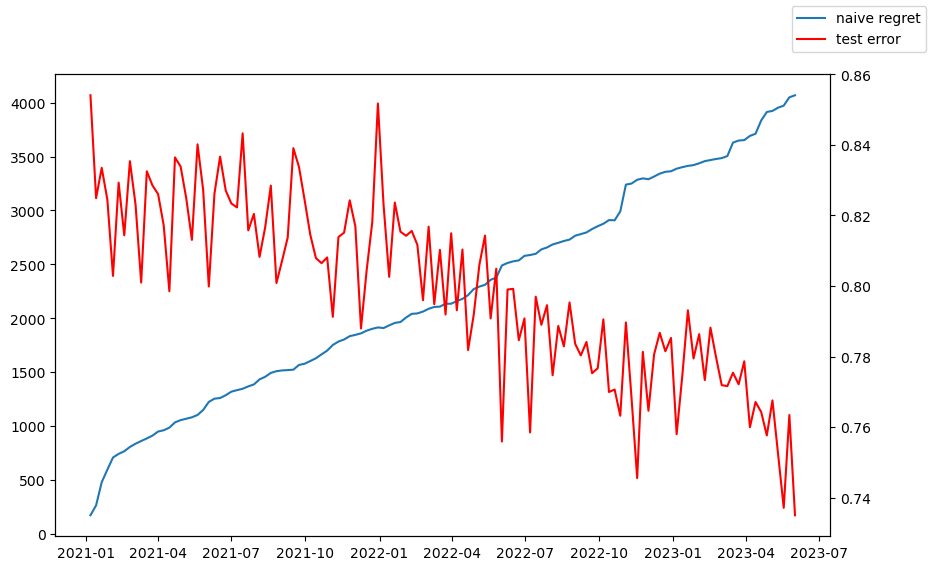

In [209]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(weekly_graphs.keys(), lp.past_naive_regrets, label='naive regret')
ax_2 = ax.twinx()
ax_2.plot(weekly_graphs.keys(), lp.test_errors, color='red', label='test error')
fig.legend()

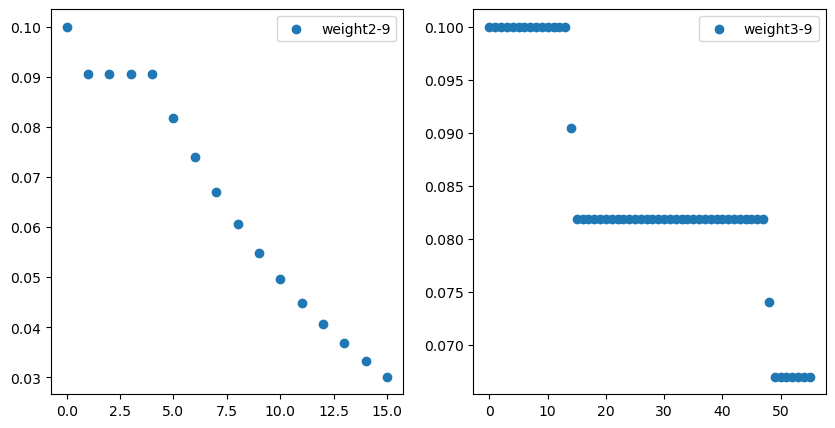

In [204]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
weight2, weight3 = np.array(lp.past_weight_vectors[('13', '60')]), np.array(lp.past_weight_vectors[('181', '155')])

weight2_e9, weight2_e5, weight2_e1 = weight2[:, 9], weight2[:, 5], weight2[:, 1]
weight3_e9, weight3_e5, weight3_e1 = weight3[:, 9], weight3[:, 5], weight3[:, 1]
ax[0].scatter(np.arange(len(weight2_e9)), weight2_e9, label='weight2-9')
# ax[0].scatter(weight2_e5, label='weight2-5')
# ax[0].scatter(weight2_e1, label='weight2-1')
ax[0].legend()

ax[1].scatter(np.arange(len(weight3_e9)), weight3_e9, label='weight3-9')
# ax[1].scatter(weight3_e5, label='weight3-5')
# ax[1].scatter(weight3_e1, label='weight3-1')
ax[1].legend()

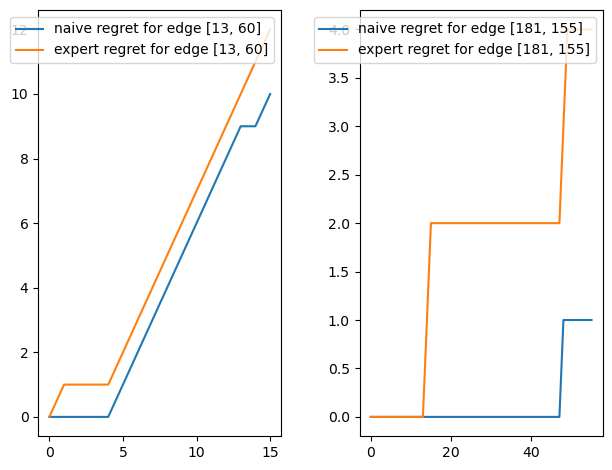

In [197]:
#naive regret vs expert regret comparison
fig, ax = plt.subplots(1,2)
naive_result2, naive_result3 = lp.naive_target_regrets[('13', '60')], lp.naive_target_regrets[('181', '155')]
result2, result3 = lp.target_regrets[('13', '60')], lp.target_regrets[('181', '155')]
ax[0].plot(np.arange(len(naive_result2)), naive_result2, label='naive regret for edge [13, 60]')
ax[0].plot(np.arange(len(result2)), result2, label='expert regret for edge [13, 60]')
ax[1].plot(np.arange(len(naive_result3)), naive_result3, label='naive regret for edge [181, 155]')
ax[1].plot(np.arange(len(result3)), result3, label='expert regret for edge [181, 155]')
ax[0].legend()
ax[1].legend()
fig.tight_layout()

In [175]:
# common = set([tuple(x) for x in lp.past_test_edges[0]]) 
# for test_edges in lp.past_test_edges[1:]: 
#     test_edge_set = set([tuple(x) for x in test_edges])
#     common.intersection(test_edge_set)
# common

In [176]:
# # follow the leader 
# # N, lookback = 136, 1
# # leader_num, learning_rate = 10, 0.1
# # leader_thresholds, weight_vector, loss_vector = np.arange(0.1, 1.1, 1/leader_num), [1/leader_num]*leader_num, [0] * leader_num

# # Input: learning rate η > 0
# # Initialize: let L0 ∈ RN be the all-zero vector
# edge_list = [['125', '527'], 
#        ['13', '60'],  
#        ['181', '155']]
# lp = TemporalPrediction(edge_list)
# # for t in range(N-lookback, N): 
# for time, graph in tqdm(weekly_graphs.items()):
#     # compute probability 
#     lp.run_expert_simulation(graph, time, display_progress=True)
    
#     # play pt and observe loss vector ℓt ∈ [0, 1]N

#     # when the correct answer is received, penalize each mistaken expert by multiplying its weight by learning_rate
#     # update Lt = Lt−1 + ℓt

In [97]:
# test = [np.array(['273', '604'], dtype=object), np.array(['664', '973'], dtype=object), np.array(['142', '806'], dtype=object), np.array(['981', '475'], dtype=object), np.array(['744', '20'], dtype=object), np.array(['28', '115'], dtype=object), np.array(['18', '268'], dtype=object)]
# print(test)
# print(set([tuple(x) for x in test]))